# `micrograd`: construction d'une bibliothèque de rétropropagation du gradient (partie 1)

Ce notebook est dérivé du travail d'[Andrej Karpathy](https://karpathy.ai/) et reprend pas à pas les étapes exposées dans sa première séance de cours sur la construction d'un outil en Python pour le calcul du gradient et sa propagation arrière:

[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

Voici les ressources originales associées à la vidéo youtube d'Andrej:

- micrograd on github: https://github.com/karpathy/micrograd
- notebook original: https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd
- exercices: https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing

## Importation de paquetages tiers

In [1]:
# Imports de la librairie standard Python
import math

In [2]:
# Imports spécifiques (doivent être présent dans l'environnement Python de ce notebook)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

## Introduction

In [3]:
# Définissons une fonction y <- f(x) arbitraire 
def f(x):
    return 3 * x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
# Tableaux de points entre -5 et 5 pour les valeurs de x, avec un pas de 0.25
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
# Calcul des y pour ces points
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

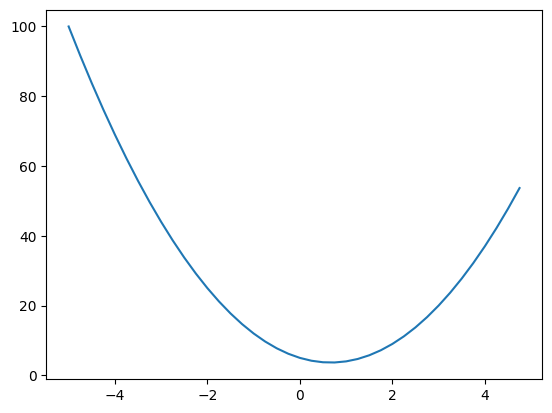

In [7]:
# Traçé de la parabole
plt.plot(xs,ys)

## Dérivations



### Pente de la tangente

$$t_{x}(h) = {f(x+h)-f(x) \over h}$$

[Taux d'accroissement](https://fr.wikipedia.org/wiki/Dérivée): _comment une fonction répond-elle quand on accroit $x$ d'un petit pas $h$_?

In [8]:
def pente(fct, x, h):
    print(f"f(x) = {fct(x)}")
    print(f"f(x + h) = {fct(x + h)}")
    print(f"f(x + h) - f(x) = {fct(x + h) - fct(x)}")
    print(f"(f(x + h) - f(x)) / h= {(fct(x + h) - fct(x)) / h}")
    return (fct(x + h) - fct(x)) / h

In [9]:
f = lambda x: 3 * x**2 - 4*x + 5
pente(f, 3.0, 0.00000001)

f(x) = 20.0
f(x + h) = 20.00000014
f(x + h) - f(x) = 1.400000009255109e-07
(f(x + h) - f(x)) / h= 14.00000009255109


14.00000009255109

In [10]:
pente(f, -3.0, 0.00000001)

f(x) = 44.0
f(x + h) = 43.999999779999996
f(x + h) - f(x) = -2.200000039920269e-07
(f(x + h) - f(x)) / h= -22.00000039920269


-22.00000039920269

In [11]:
pente(f, 2/3, 0.00000001)

f(x) = 3.666666666666667
f(x + h) = 3.666666666666667
f(x + h) - f(x) = 0.0
(f(x + h) - f(x)) / h= 0.0


0.0

### Expression arithmétique plus complexe

In [12]:
# Prenons une expression arithmétique plus complexe
a = 2.0
b = -3.0
c = 10.0
f = lambda x, y, z: x*y + z
print(f(a,b,c))

4.0


In [13]:
# Dérivée de f par rapport à a, b, c?
h = 0.0001
# Entrées
a = 2.0
b = -3.0
c = 10.0

In [14]:
# Dérivée de f par rapport à a
f_1 = f(a, b, c)
f_2 = f(a+h, b, c)
print(f_1)
print(f_2)
print("pente", (f_2-f_1)/h)


4.0
3.999699999999999
pente -3.000000000010772


In [15]:
# Dérivée de f par rapport à b
f_1 = f(a, b, c)
f_2 = f(a, b+h, c)
print(f_1)
print(f_2)
print("pente", (f_2-f_1)/h)


4.0
4.0002
pente 2.0000000000042206


In [16]:
# Dérivée de f par rapport à c
f_1 = f(a, b, c)
f_2 = f(a, b, c+h)
print(f_1)
print(f_2)
print("pente", (f_2-f_1)/h)


4.0
4.0001
pente 0.9999999999976694


## Création d'une classe Value

### Première version

In [17]:
class Value:
  
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

In [18]:
a = Value(2.0)
a

Value(data=2.0)

In [19]:
b = Value(-3.0)
b

Value(data=-3.0)

### Addition

In [20]:
class Value:
  
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    return self.__class__(self.data + other.data)

In [21]:
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

### Multiplication

In [21]:
class Value:
  
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    return self.__class__(self.data + other.data)

  def __mul__(self, other):
    return self.__class__(self.data * other.data)

In [22]:
a = Value(2.0)
b = Value(-3.0)
a * b

Value(data=-6.0)

In [23]:
c = Value(10.0)
a*b + c

Value(data=4.0)

### Construction d'un graphe correspondant à l'expression

In [24]:
class Value:
  
  def __init__(self, data, children=(), op=''):
    self.data = data
    self._prev = set(children)
    self._op = op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    return self.__class__(self.data + other.data, children=(self, other), op='+')

  def __mul__(self, other):
    return self.__class__(self.data * other.data, children=(self, other), op='*')

In [25]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
d

Value(data=4.0)

In [26]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

### Affichage du graphe avec graphviz

In [30]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

In [31]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f }" % n.data, shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

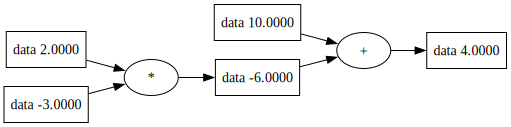

In [32]:
draw_dot(d)

### Amélioration de l'affichage avec un label

In [33]:
class Value:
  
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self._prev = set(children)
    self._op = op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label})"

  def __add__(self, other):
    return self.__class__(self.data + other.data, children=(self, other), op='+')

  def __mul__(self, other):
    return self.__class__(self.data * other.data, children=(self, other), op='*')

In [34]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [35]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'

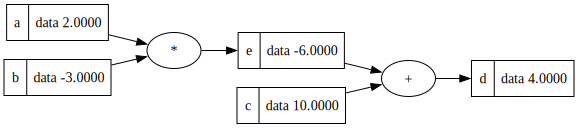

In [36]:
draw_dot(d)

### Fonction objectif: fonction de perte

In [37]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0, label=L)

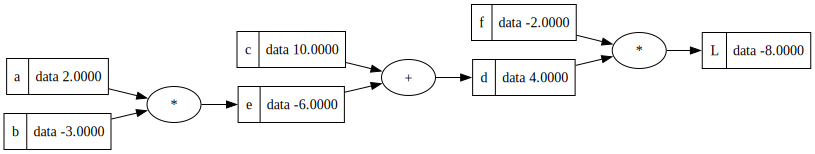

In [38]:
draw_dot(L)

À ce stade, nous pouvons faire une passe avant (_forward pass_), dans une expression mathématique. Nous voulons maintenant pouvoir faire une propagation arrière du gradient, à partir de $L$, pour déterminer les gradients sur les chemins du graphe en remontant. On va donc calculer les dérivées de chaque noeud par rapport à $L$.


## Calcul des gradients à la main

### Stockage des gradients dans Value

In [39]:
class Value:
  
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self._prev = set(children)
    self._op = op
    self.label = label
    self.grad = 0.0

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

  def __add__(self, other):
    return self.__class__(self.data + other.data, children=(self, other), op='+')

  def __mul__(self, other):
    return self.__class__(self.data * other.data, children=(self, other), op='*')

Affichage du gradient dans les noeuds du graphe:

In [2]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

NameError: name 'Value' is not defined

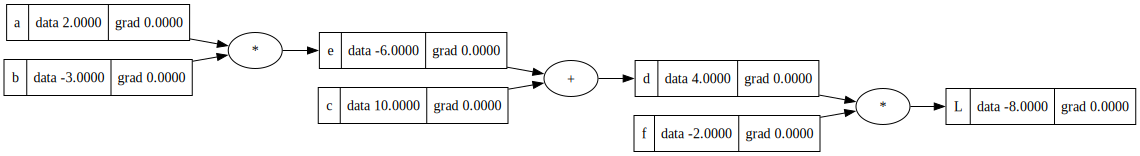

In [42]:
draw_dot(L)

### Jouons avec les dérivées

In [4]:
def playground():

    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    #e.data += h
    d = e + c
    d.label = 'd'
    #d.data += h
    f = Value(-2.0, label='f')
    #f.data += h
    L = d * f
    L.label = 'L'
    L2 = L.data
    L2 = L.data + h

    print((L2-L1)/h)

playground()    

NameError: name 'Value' is not defined

In [51]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L.grad = 1

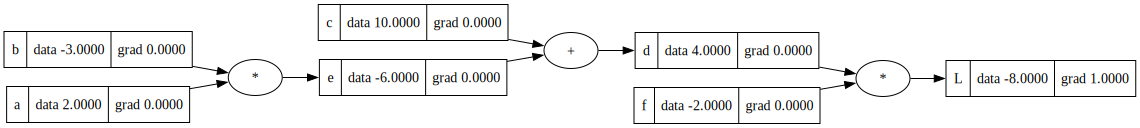

In [52]:
draw_dot(L)


In [53]:
d.grad = -2.0  # dL/dd = d(d*f)/dd = f
f.grad = 4.0  # dL/df = d(d*f)/df = d

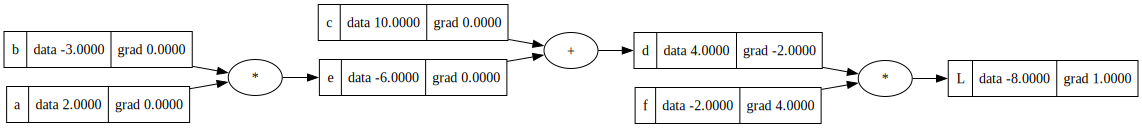

In [54]:
draw_dot(L)

### Propagation des gradients locaux: dérivation des fonctions composées (chain rule)

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$


In [55]:
# d = e + c
# dd/dc = 1.0 
# dd/de = 1.0
# (dérivées locales)
# dL/dc = dL/dd * dd/dc = d.grad * 1.0
# dL/de = dL/dd * dd/de = d.grad * 1.0
c.grad = d.grad
e.grad = d.grad

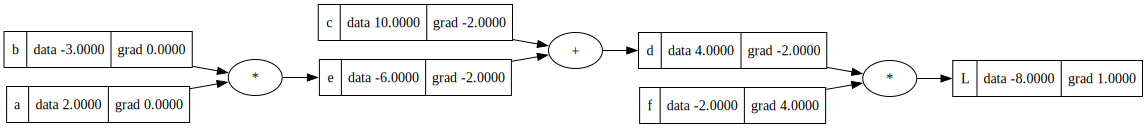

In [56]:
draw_dot(L)

In [57]:
# dL/de = -2.0
# dL/da = dL/de * de/da
# dL/db = dL/de * de/db
# de/da = b = -3.0
# de/db = a = 2.0
# dL/da = -2.0 * -3.0
# dL/db = -2.0 * 2.0
a.grad = d.grad * b.data
b.grad = d.grad * a.data

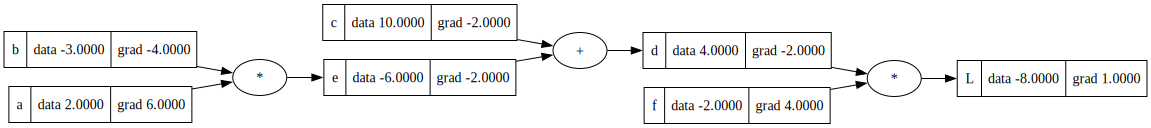

In [58]:
draw_dot(L)

In [60]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
L = e * f; L.label = 'L'
print(L)

Value(data=-6.586368000000001, label=L, grad=0.0)


## Méthodes pour la propagation arrière automatique du gradient

### Ajout d'une fonction tanh

$$\tanh x={\frac {\sinh x}{\cosh x}}={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}={\frac {e^{2x}-1}{e^{2x}+1}}$$

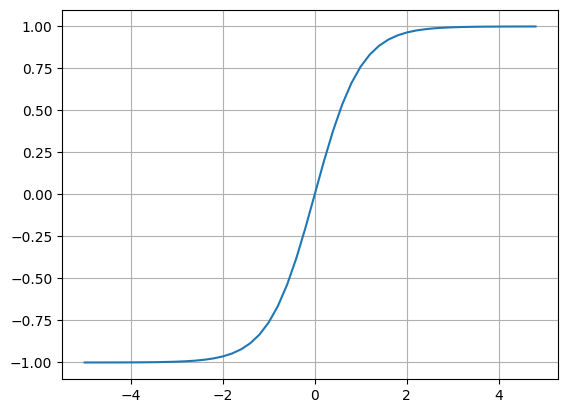

In [61]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()  # Activation function (tanh or sigmoid)

In [62]:
class Value:
  
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self._prev = set(children)
    self._op = op
    self.label = label
    self.grad = 0.0

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

  def __add__(self, other):
    return self.__class__(self.data + other.data, children=(self, other), op='+')

  def __mul__(self, other):
    return self.__class__(self.data * other.data, children=(self, other), op='*')

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, children=(self, ), op='tanh')
    return out

### Implémentation d'un parcours arrière pour calculer les gradients (backward)


In [63]:
class Value:
  
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self._prev = set(children)
    self._op = op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

  def __add__(self, other):
    out = self.__class__(self.data + other.data, children=(self, other), op='+')
    def _backward():
        self.grad = out.grad 
        other.grad = out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = self.__class__(self.data * other.data, children=(self, other), op='*')
    def _backward():
        self.grad = other.data * out.grad 
        other.grad = self.data * out.grad
    out._backward = _backward
    return out
    
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, children=(self,), op='tanh')
    def _backward():
        self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

Utilisation à la main:

In [64]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L.grad = 1.0

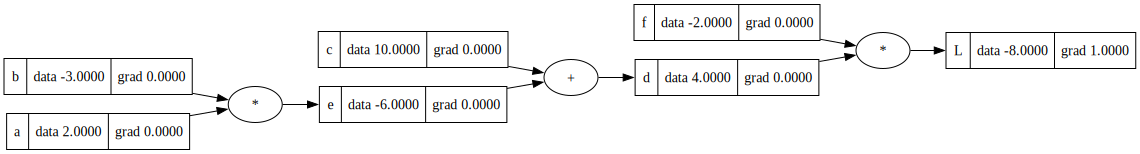

In [67]:
draw_dot(L)

In [68]:
L._backward()

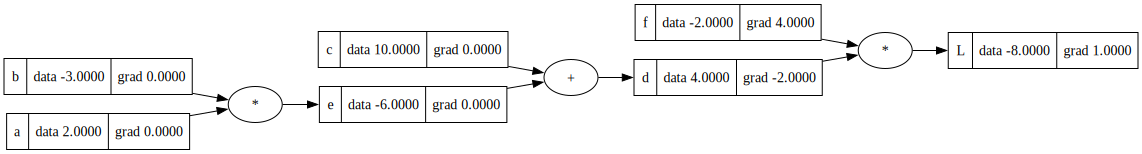

In [69]:
draw_dot(L)

In [70]:
d._backward()

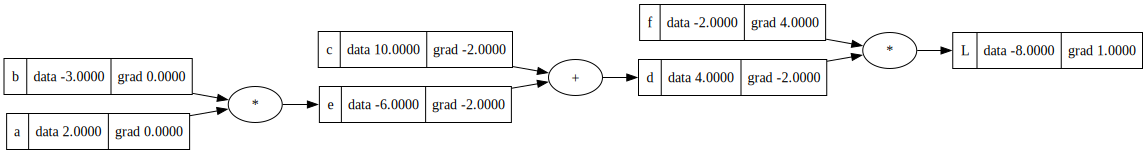

In [71]:
draw_dot(L)

In [72]:
e._backward()

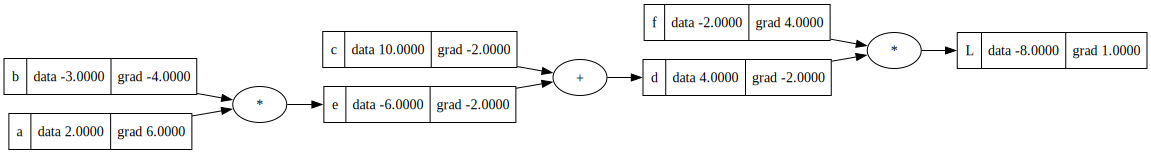

In [73]:
draw_dot(L)

On peut vérifier que les valeurs sont identiques à ce que nous avions calculé tout à l'heure à main.

### Automatisation du calcul

On va ajouter à la classe `Value` une méthode `backward` qui permettra d'appeler dans en remontant dans le graphe les méthodes `_backward` définies lors de la passe "forward" de construction du graphe, capturant le calcul à effectuer ainsi que l'objet `Value` parent qui fournira son gradient.

On effectue un [tri topologique](https://fr.wikipedia.org/wiki/Tri_topologique) sur les noeuds du graphe (tri possible car les graphes que nous construisons sonr des DAG dans nos exemples), puis on applique en "remontant" `_backward`: le tri topologique assure que les gradients nécessaires au calcul ont bien été calculés avant.

In [76]:
# Passer d'un mode manuel à une automatisation de la back propagation
# Tri topologique du DAG de l'expression
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
Value.backward = backward

In [77]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [78]:
L.backward()

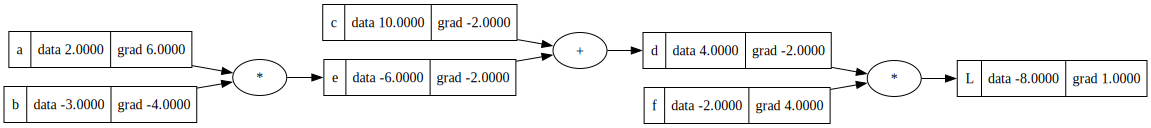

In [79]:
draw_dot(L)

**fin de la première partie**